In [1]:
%matplotlib inline
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from metpy.units import units
import numpy as np
import metpy.calc as mpcalc
from metpy.plots.ctables import colortables
from matplotlib import rcParams, colors
import xarray as xr


In [44]:
def getdata(year=2001,month=4, day=12, hour=12, save=False):
    dt = datetime(year, month, 1)

    # Grab Pressure Level Data
    hght_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/hgt.{dt:%Y%m}.nc')
    air_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                               f'NARR/pressure/air.{dt:%Y%m}.nc')
    shum_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/shum.{dt:%Y%m}.nc')
    uwnd_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/uwnd.{dt:%Y%m}.nc')
    vwnd_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/pressure/vwnd.{dt:%Y%m}.nc')
    mslp_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/monolevel/prmsl.{dt:%Y}.nc')
    uwnd10_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                  f'NARR/monolevel/uwnd.10m.{dt:%Y}.nc')
    vwnd10_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                  f'NARR/monolevel/vwnd.10m.{dt:%Y}.nc')
    air2_data = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                                f'NARR/monolevel/air.2m.{dt:%Y}.nc')

    # Pull out the lat and lon data
    lat = hght_data.lat.values
    lon = hght_data.lon.values

    plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                    standard_parallels=[30, 60])

    datacrs = ccrs.PlateCarree()

    tlatslons = plotcrs.transform_points(datacrs, lon, lat)
    tlon = tlatslons[:, :, 0]
    tlat = tlatslons[:, :, 1]

    dt = datetime(year, month, day, hour)
    vtimes = hght_data.time.sel(time=dt).values.astype('datetime64[ms]').astype('O')

    hght_1000 = mpcalc.smooth_n_point(hght_data.hgt.sel(time=dt, level=1000), 9, 10)
    hght_500 = mpcalc.smooth_n_point(hght_data.hgt.sel(time=dt, level=500), 9, 10)
    uwnd_500 = mpcalc.smooth_n_point(uwnd_data.uwnd.sel(time=dt, level=500), 9, 10)
    vwnd_500 = mpcalc.smooth_n_point(vwnd_data.vwnd.sel(time=dt, level=500), 9, 10)
    
    hght_850 = mpcalc.smooth_n_point(hght_data.hgt.sel(time=dt, level=850), 9, 10)
    uwnd_850 = mpcalc.smooth_n_point(uwnd_data.uwnd.sel(time=dt, level=850), 9, 10)
    vwnd_850 = mpcalc.smooth_n_point(vwnd_data.vwnd.sel(time=dt, level=850), 9, 10)
    tmpc_850 = (mpcalc.smooth_n_point(air_data.air.sel(time=dt, level=850), 9, 10)).to('degC')
    tmpc_700 = (mpcalc.smooth_n_point(air_data.air.sel(time=dt, level=700), 9, 10)).to('degC')
    shum_700 = mpcalc.smooth_n_point(shum_data.shum.sel(time=dt, level=700), 9, 10)
    hght_300 = mpcalc.smooth_n_point(hght_data.hgt.sel(time=dt, level=300), 9, 10)
    uwnd_300 = mpcalc.smooth_n_point(uwnd_data.uwnd.sel(time=dt, level=300), 9, 10)
    vwnd_300 = mpcalc.smooth_n_point(vwnd_data.vwnd.sel(time=dt, level=300), 9, 10)
    
    mslp = (mpcalc.smooth_n_point(mslp_data.prmsl.sel(time=dt), 9, 10)).to('hPa')
    uwnd10 = mpcalc.smooth_n_point(uwnd10_data.uwnd.sel(time=dt), 9, 10)
    vwnd10 = mpcalc.smooth_n_point(vwnd10_data.vwnd.sel(time=dt), 9, 10)
    tmpf2 = (mpcalc.smooth_n_point(air2_data.air.sel(time=dt), 9, 10)).to('degF')
    pcpin = hght_1000 * 0.0
    
    dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
    absvort_500 = mpcalc.absolute_vorticity(uwnd_500, vwnd_500, dx, dy, lat*units.degree)*1e5
    
    wspd_300 = mpcalc.wind_speed(uwnd_300, vwnd_300).to('kts')
    
    e_700 = mpcalc.vapor_pressure(700.*units('hPa'), shum_700)
    es_700 = mpcalc.saturation_vapor_pressure(tmpc_700.to('K'))
    relh_700 = e_700 / es_700 * 100
    
    # To set the map area, need to convert to proper coords.
    LL = plotcrs.transform_point(-125., 22., ccrs.PlateCarree())
    UR = plotcrs.transform_point(-55., 52., ccrs.PlateCarree())
    
    def plot_background(num, crs1):
        ax = plt.subplot(num, projection=crs1)
        #   ax.set_extent([west long, east long, south lat, north lat])
        ax.set_extent([LL[0], UR[0], LL[1], UR[1]], crs1)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black', linewidth=0.75)
        return ax
    
    clevpmsl = np.arange(800, 1100, 4)
    clev850 = np.arange(0, 5000, 30)
    clevrh700 = [50, 70, 80, 90, 100]
    clevtmpc850 = np.arange(-50, 51, 2)
    clev500 = np.arange(0, 10000, 60)
    clev300 = np.arange(0, 15000, 120)
    clevsped300 = np.arange(50, 230, 20)
    clevprecip = [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50,
                  0.60, 0.70, 0.80, 0.90, 1.00, 1.25, 1.50, 1.75, 2.00, 2.50]
    clevavor500 = list(range(-8, 1, 1))+list(range(8, 49, 2))
    colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 31))
    colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
    colorsavor500 = np.vstack((colors2, (1, 1, 1, 1), colors1))
    clevtmpf2 = np.arange(-60, 120, 5)
    
    wind_slice = [slice(None, None, 8), slice(None, None, 8)]
    
    fig=plt.figure(1, figsize=(22., 13.))
    fig.subplots_adjust(top=1, bottom=0, hspace=0.0, wspace=0.01)
        
    # Following line is to get wind barbs properly on the correct projection
    # udat, vdat, xv, yv = m.transform_vector(uwnd_500[0,:,:],vwnd_500[0,:,:],tlon1,tlat1,15,21,returnxy=True)
    # Upper-left panel MSLP, 1000-500 hPa Thickness, Precip (in)
    ax1 = plot_background(221, plotcrs)
    ax1.set_extent([230., 290., 20., 55.], ccrs.PlateCarree())
    plt.title('MSLP (hPa), 2m TMPF, and 1000-500 hPa Thickness (m)', loc='left')
    plt.title(f'VALID: {dt}', loc='right')
    cmap = plt.cm.coolwarm
    cf = ax1.contourf(tlon, tlat, tmpf2, clevtmpf2, cmap=cmap, extend='both')
    cbar = plt.colorbar(cf, orientation='horizontal', extend='both', aspect=65, pad=0, extendrect='True')
    ax1.barbs(lon[wind_slice], lat[wind_slice],
              (uwnd10[wind_slice].to('kts')).m, (vwnd10[wind_slice].to('kts')).m,
              length=6, transform=datacrs)
    cs2 = ax1.contour(tlon, tlat, hght_500-hght_1000, clev500, colors='grey', linewidths=1.5, linestyles='dashed')
    cs  = ax1.contour(tlon, tlat, mslp, clevpmsl, colors='black', linewidths=1.5)
    plt.clabel(cs, fontsize=10, inline=True, fmt='%d', rightside_up=True)
    plt.clabel(cs2, fontsize=9, inline=True, fmt='%d', rightside_up=True)
        
    # Upper-right panel 850-hPa Heights and Temp (C)
    ax2 = plot_background(222, plotcrs)
    ax2.set_extent([230., 290., 20., 55.], ccrs.PlateCarree())
    cmap = plt.cm.Greens
    cf = ax2.contourf(tlon, tlat, relh_700, clevrh700, cmap=cmap, extend='both', norm=plt.Normalize(50, 120))
    cbar = plt.colorbar(cf, orientation='horizontal', extend='both', aspect=65, pad=0, extendrect='True')
    cs1 = ax2.contour(tlon, tlat, tmpc_850, clevtmpc850, colors='tab:red', linewidths=1.5, linestyles=':', alpha=0.75)
    cs = ax2.contour(tlon, tlat, hght_850, clev850, colors='black', linewidths=1.5)
    ax2.barbs(lon[wind_slice], lat[wind_slice],
              (uwnd_850[wind_slice].to('kts')).m, (vwnd_850[wind_slice].to('kts')).m,
              length=6, transform=datacrs)
    plt.clabel(cs, fontsize=10, inline=True, fmt='%d', rightside_up=True)
    plt.clabel(cs1, fontsize=10, inline=True, fmt='%d')
    plt.title('850-hPa HGHTs (m) and TMPC', loc='left')
    plt.title(f'VALID: {dt}', loc='right')
        
    # Lower-left panel 500-hPa Heights and AVOR
    ax3 = plot_background(223, plotcrs)
    ax3.set_extent([230., 290., 20., 55.], ccrs.PlateCarree())
    cf = ax3.contourf(tlon, tlat, absvort_500, clevavor500, colors=colorsavor500, extend='both')
    cs1 = ax3.contour(tlon, tlat, absvort_500, clevavor500, colors='black', linewidths=1.5, linestyles=':', alpha=0.5)
    cbar = plt.colorbar(cf, orientation='horizontal', extend='both', aspect=65, pad=0, extendrect='True')
    cs = ax3.contour(tlon, tlat, hght_500[:,:], clev500, colors='black', linewidths=1.5)
    ax3.barbs(lon[wind_slice], lat[wind_slice],
              (uwnd_500[wind_slice].to('kts')).m, (vwnd_500[wind_slice].to('kts')).m,
              length=6, transform=datacrs)
    plt.clabel(cs, fontsize=10, inline=True, fmt='%d', rightside_up=True)
    plt.title('500-hPa HGHTs (m) and AVOR ($*10^5$ $s^{-1}$)', loc='left')
    plt.title(f'VALID: {dt}', loc='right')
        
    # Lower-right panel 300-hPa Heights and Wind Speed (kts)
    ax4 = plot_background(224, plotcrs)
    ax4.set_extent([230., 290., 20., 55.], ccrs.PlateCarree())
    cmap = plt.cm.get_cmap("BuPu")
    cf = ax4.contourf(tlon, tlat, wspd_300, clevsped300, cmap=cmap, extend='max')
    cs1 = ax4.contour(tlon, tlat, wspd_300, clevsped300, colors='black', linestyles=':', alpha=0.5)
    cbar = plt.colorbar(cf, orientation='horizontal', extend='max', aspect=65, pad=0, extendrect='True')
    cs = ax4.contour(tlon, tlat, hght_300, clev300, colors='k', linewidths=1.5)
    ax4.barbs(lon[wind_slice], lat[wind_slice],
              (uwnd_300[wind_slice].to('kts')).m, (vwnd_300[wind_slice].to('kts')).m,
              length=6, transform=datacrs)
    plt.clabel(cs, fontsize=10, inline=True, fmt='%d', rightside_up=True)
    plt.title('300-hPa HGHTs (m) and SPED (kts)', loc='left')
    plt.title(f'VALID: {dt}', loc='right')
    
    if save:
        plt.savefig(f'NARR_{dt:%Y%m%d}_{dt:%H00}.png', dpi=150)
        plt.close()
    else:
        plt.show()



In [3]:
year_widget = widgets.Dropdown(
    options=list(range(1979,2017)),
    description='Year', alignment='center')
month_widget = widgets.Dropdown(
    options=list(range(1,13)),
    description='Month', alignment='center')
day_widget = widgets.Dropdown(description='Day', options=list(range(1,32)))
hour_widget = widgets.Dropdown(description='Hour', options=[0,3,6,9,12,15,18,21])


In [4]:
x = widgets.interact_manual(getdata,year=year_widget,month=month_widget, day=day_widget, hour=hour_widget)

interactive(children=(Dropdown(description='Year', options=(1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 19…

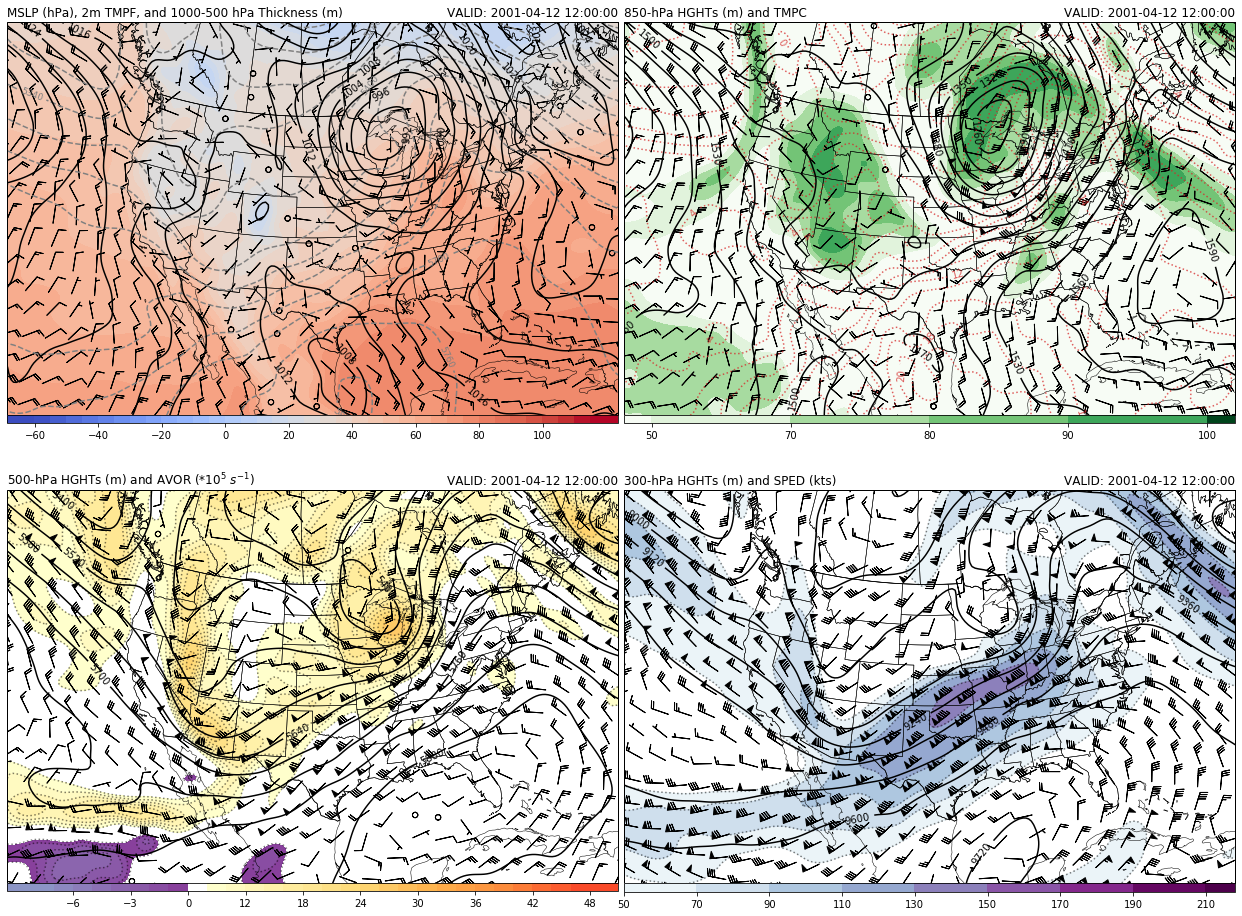

In [45]:
getdata()